# Loss Landscape Analysis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import pandas as pd

In [4]:
total_qubits = 10
layers = 8
dev = qml.device("default.qubit", wires=total_qubits)

In [5]:
def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly Ansatz."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid Ansatz: Progressive entanglement """
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement ansatz"""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement ansatz with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return brick_ansatz(params)


In [6]:
def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(params):
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

In [7]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the CSV file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('Stoxx15_24.csv')

In [8]:
# param_range = np.linspace(-np.pi, np.pi, 100)
# param_grid = np.meshgrid(param_range, param_range)
# param_grid = np.array(param_grid).reshape(2, -1).T

# cost_values = []
# for param in param_grid:
#     params = np.zeros((layers, total_qubits, 3))
#     params[0, 0, 0] = param[0]
#     params[0, 1, 1] = param[1]
#     cost_values.append(cost(params))

# cost_values = np.array(cost_values).reshape(100, 100)

# plt.figure(figsize=(10, 6))
# plt.contourf(param_range, param_range, cost_values, levels=50, cmap='viridis')
# plt.colorbar(label='Cost')
# plt.xlabel('Parameter 1')
# plt.ylabel('Parameter 2')
# plt.title('Loss Landscape of the Quantum Circuit')
# plt.show()

In [9]:

# param_range = np.linspace(-np.pi, np.pi, 50)
# param_grid = np.meshgrid(param_range, param_range)
# param_grid = np.array(param_grid).reshape(2, -1).T

# # Evaluate the cost function for each set of parameters in the grid
# cost_values = []
# for param in param_grid:
#     params = np.zeros((layers, total_qubits, 3))
#     params[0, 0, 0] = param[0]
#     params[0, 1, 1] = param[1]
#     cost_values.append(cost(params))

# cost_values = np.array(cost_values).reshape(50, 50)

# # Create a 3D plot of the loss landscape
# X, Y = np.meshgrid(param_range, param_range)
# Z = cost_values

# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')

# ax.set_xlabel('Parameter 1')
# ax.set_ylabel('Parameter 2')
# ax.set_zlabel('Cost')
# ax.set_title('3D Loss Landscape of the Quantum Circuit')

# plt.show()

In [10]:
%matplotlib widget

In [11]:

# import pennylane as qml
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import pdist, squareform
# from sklearn.cluster import MeanShift
# from mpl_toolkits.mplot3d import Axes3D


# layers = 3
# total_qubits = 5
# dev = qml.device("default.qubit", wires=total_qubits)

# @qml.qnode(dev, diff_method="parameter-shift")
# def quantum_model(params):
#     return butterfly_ansatz(params)

# def kl_divergence(p, q):
#     p = np.where(p == 0, 1e-10, p)
#     q = np.where(q == 0, 1e-10, q)
#     return np.sum(p * np.log(p / q))

# def cost(params, training_data):
#     quantum_probs = quantum_model(params)
#     empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
#     return kl_divergence(empirical_probs, quantum_probs)


# def visualize_loss_landscape(param_set, training_data):
#     """
#     Generate a 3D surface plot of the loss landscape.
    
#     param_set is assumed to have shape (p1, p2, layers, total_qubits, 3) or similar.
#     Each point in the p1 x p2 grid is a different set of parameters for the Brick Ansatz.
#     """
#     p1, p2 = param_set.shape[:2]

#     # Random initialization of parameters for each point in the (p1, p2) grid
#     param_vecs = np.random.uniform(-np.pi, np.pi, size=(p1, p2, layers, total_qubits, 3))  

#     loss_values = np.zeros((p1, p2))
#     for i in range(p1):
#         for j in range(p2):
#             loss_values[i, j] = cost(param_vecs[i, j], training_data)

#     # Use indexing='ij' so X, Y, Z all have shape (p1, p2)
#     X, Y = np.meshgrid(range(p1), range(p2), indexing='ij')
#     Z = loss_values

#     fig = plt.figure(figsize=(10, 6))
#     ax = Axes3D(fig) 
#     ax = fig.add_subplot(111, projection='3d')

#     surface = ax.plot_surface(X, Y, Z, cmap='viridis')
#     fig.colorbar(surface, shrink=0.6, aspect=10, label='Loss Value')

#     ax.set_xlabel('Parameter Axis i (Grid Index)', labelpad=15)
#     ax.set_ylabel('Parameter Axis j (Grid Index)', labelpad=15)
#     ax.set_zlabel('KL Divergence (Loss)', labelpad=10)
#     ax.set_title('3D Loss Landscape', pad=20)
#     plt.show()


In [ ]:
# params = np.random.uniform(-np.pi, np.pi, (layers, total_qubits, 3))
 
# param_set_example = np.random.uniform(
#     -np.pi, 
#     np.pi, 
#     size=(50, 50, layers, total_qubits, 3)
# )

# visualize_loss_landscape(param_set_example, training_data)

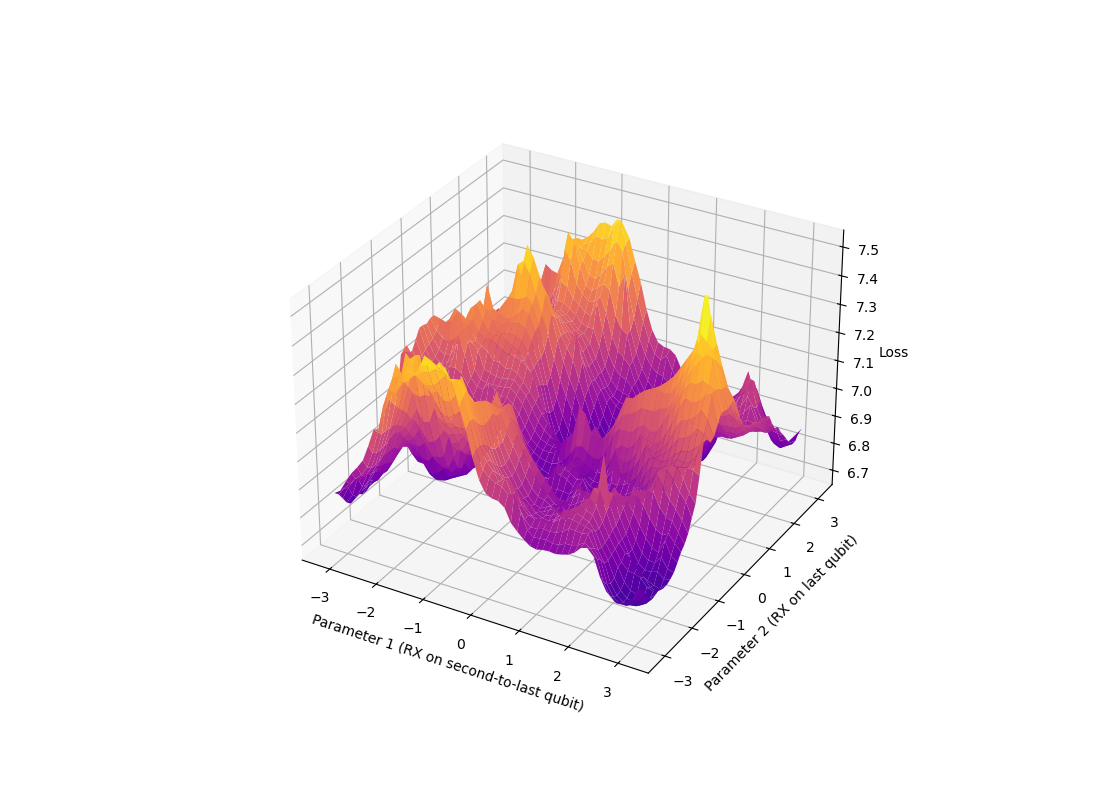

In [29]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

layers = 8
total_qubits = 11
dev = qml.device("default.qubit", wires=total_qubits)


def brick_ansatz(fixed_params, variable_params):
    """Standard Brick QCBM with fixed and variable parameters."""
    for l in range(layers):
        for i in range(total_qubits):
            if l == layers - 1 and i >= total_qubits - 2:
                # Use variable parameters for the last two qubits in the last layer
                qml.RX(variable_params[i - (total_qubits - 2), 0], wires=i)
                qml.RY(variable_params[i - (total_qubits - 2), 1], wires=i)
                qml.RZ(variable_params[i - (total_qubits - 2), 2], wires=i)
            else:
                # Use fixed parameters for all other qubits and layers
                qml.RX(fixed_params[l, i, 0], wires=i)
                qml.RY(fixed_params[l, i, 1], wires=i)
                qml.RZ(fixed_params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(fixed_params, variable_params):
    return brick_ansatz(fixed_params, variable_params)

def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(variable_params, fixed_params):
    quantum_probs = quantum_model(fixed_params, variable_params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)


fixed_params = np.random.rand(layers, total_qubits, 3)  # Random fixed parameters
variable_params = np.random.rand(2,3)  

param1_values = np.linspace(-np.pi, np.pi, 50)  
param2_values = np.linspace(-np.pi, np.pi, 50)  
loss_values = np.zeros((len(param1_values), len(param2_values)))

for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        variable_params[0, 0] = param1  # Vary the first parameter (e.g., RX on the second-to-last qubit)
        variable_params[1, 0] = param2  # Vary the second parameter (e.g., RX on the last qubit)
        loss_values[i, j] = cost(variable_params, fixed_params)


fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
param1_grid, param2_grid = np.meshgrid(param1_values, param2_values)
ax.plot_surface(param1_grid, param2_grid, loss_values, cmap='plasma')

ax.set_xlabel('Parameter 1 (RX on second-to-last qubit)')
ax.set_ylabel('Parameter 2 (RX on last qubit)')
ax.set_zlabel('Loss')

plt.show()

In [30]:
def brick_ansatz(fixed_params, variable_params, target_layers):
    """Standard Brick QCBM with fixed and variable parameters."""
    for l in range(layers):
        for i in range(total_qubits):
            if l in target_layers and i == total_qubits - 1:
                # Use variable parameters for the last RZ gate on the target layers
                qml.RX(fixed_params[l, i, 0], wires=i)
                qml.RY(fixed_params[l, i, 1], wires=i)
                qml.RZ(variable_params[target_layers.index(l)], wires=i)
            else:
                # Use fixed parameters for all other qubits and layers
                qml.RX(fixed_params[l, i, 0], wires=i)
                qml.RY(fixed_params[l, i, 1], wires=i)
                qml.RZ(fixed_params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(fixed_params, variable_params, target_layers):
    return brick_ansatz(fixed_params, variable_params, target_layers)

def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(variable_params, fixed_params, target_layers):
    quantum_probs = quantum_model(fixed_params, variable_params, target_layers)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)


fixed_params = np.random.rand(layers, total_qubits, 3)  # Random fixed parameters
target_layers = [4, 6]  # Layers where the last RZ gate will vary
variable_params = np.random.rand(len(target_layers))  # Random initial variable parameters for the target layers

param1_values = np.linspace(-np.pi, np.pi, 50)  # Range for the first parameter
param2_values = np.linspace(-np.pi, np.pi, 50)  # Range for the second parameter
loss_values = np.zeros((len(param1_values), len(param2_values)))

for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        variable_params[0] = param1  # Vary the RZ gate on the first target layer
        variable_params[1] = param2  # Vary the RZ gate on the second target layer
        loss_values[i, j] = cost(variable_params, fixed_params, target_layers)


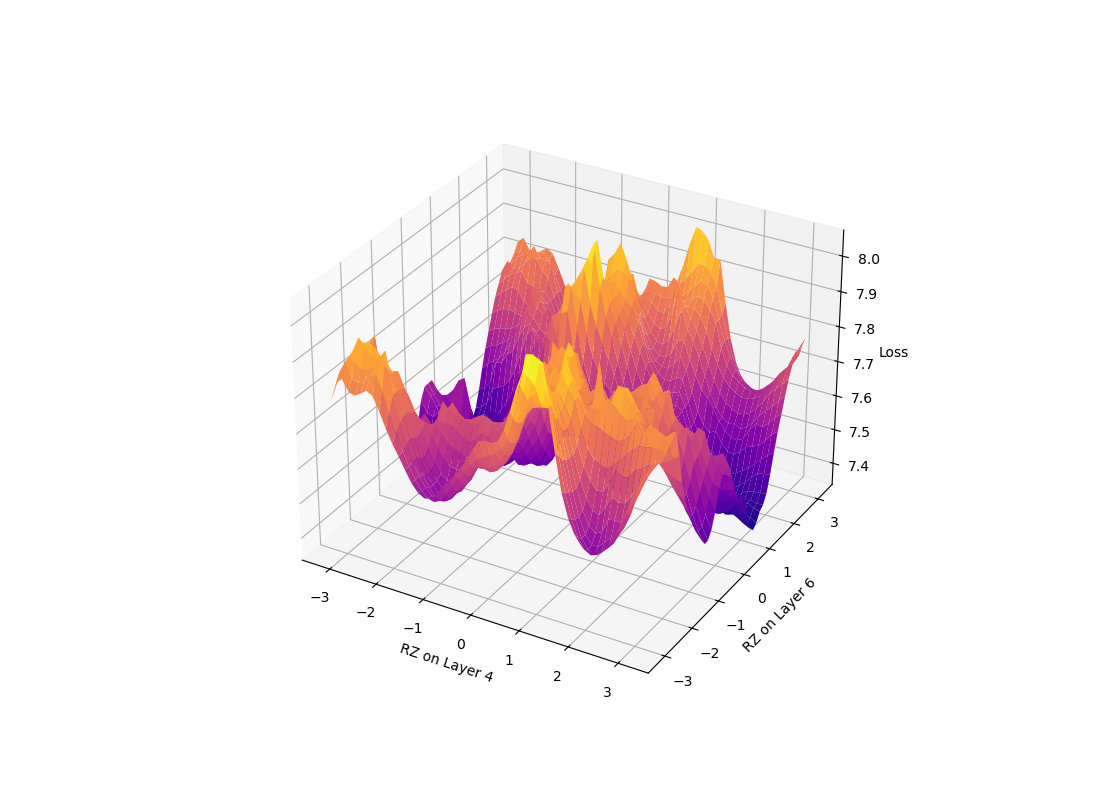

In [31]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
param1_grid, param2_grid = np.meshgrid(param1_values, param2_values)
ax.plot_surface(param1_grid, param2_grid, loss_values, cmap='plasma')

ax.set_xlabel(f'RZ on Layer {target_layers[0]} ')
ax.set_ylabel(f'RZ on Layer {target_layers[1]} ')
ax.set_zlabel('Loss')

plt.show()

In [32]:
def brick_ansatz(fixed_params, variable_params, target_layers):
    """Standard Brick QCBM with fixed and variable parameters."""
    for l in range(layers):
        for i in range(total_qubits):
            if l in target_layers and i == 0: 
                qml.RX(variable_params[target_layers.index(l)], wires=i)
                qml.RY(fixed_params[l, i, 1], wires=i)
                qml.RZ(fixed_params[l, i, 2], wires=i)
            else:
                qml.RX(fixed_params[l, i, 0], wires=i)
                qml.RY(fixed_params[l, i, 1], wires=i)
                qml.RZ(fixed_params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(fixed_params, variable_params, target_layers):
    return brick_ansatz(fixed_params, variable_params, target_layers)

def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(variable_params, fixed_params, target_layers):
    quantum_probs = quantum_model(fixed_params, variable_params, target_layers)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)


fixed_params = np.random.rand(layers, total_qubits, 3) 
target_layers = [1, 2]  
variable_params = np.random.rand(len(target_layers)) 


param1_values = np.linspace(-np.pi, np.pi, 50) 
param2_values = np.linspace(-np.pi, np.pi, 50)  
loss_values = np.zeros((len(param1_values), len(param2_values)))

for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        variable_params[0] = param1  
        variable_params[1] = param2  
        loss_values[i, j] = cost(variable_params, fixed_params, target_layers)

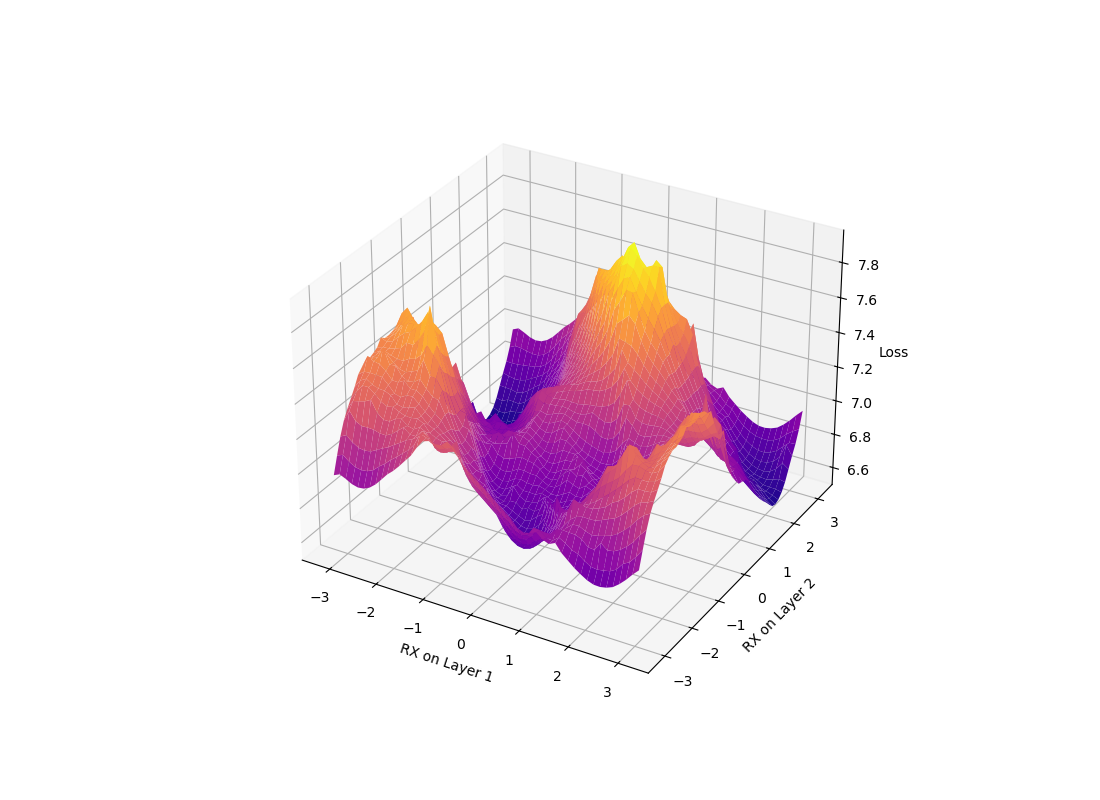

In [33]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection='3d')
param1_grid, param2_grid = np.meshgrid(param1_values, param2_values)
ax.plot_surface(param1_grid, param2_grid, loss_values, cmap='plasma')

ax.set_xlabel(f'RX on Layer {target_layers[0]} ')
ax.set_ylabel(f'RX on Layer {target_layers[1]} ')
ax.set_zlabel('Loss')

plt.show()